# Learning DSSData 

In this tutorial, we will learn the main concepts of DSSData. For that, we will run a probabilistic power flow on the [IEEE 13 bus](https://site.ieee.org/pes-testfeeders/resources/) (the ```.dss``` file can be found in OpenDSS install directory) with two turbine wind generators to observe the impact on the transformer substation losses in the distribution system. 

<figure>
    <img src="IEEE-13-bus.png" alt="run_static_pf">	
</figure>


## Loading your .dss file 

To load your ``` .dss``` file, we import the class ``` SystemClass```  and instantiate it, indicating the path to the ``` .dss``` file and the base system voltage. If all goes well, you can see the name of the distribution system.


In [9]:
from dssdata import SystemClass

path = "IEEE13bus/IEEE13Nodeckt.dss"

distSys = SystemClass(path=path, kV=[115, 4.16, 0.48])
print(distSys.name)

ieee13nodeckt


## Run power flow

### Static power flow
To run a power flow mode, we need to import a mode from ```dssdata.pfmodes```. 

The DSSData has some build-in tools that we can using for a quick start. We will talk about ```Tools``` in the next topic, for now we can use the ```voltages``` tool for run a static power flow using ```run_static_pf``` mode and get some voltages.


In [10]:
from dssdata.pfmodes import run_static_pf
from dssdata.tools import voltages

[busVoltageDF] = run_static_pf(distSys, tools=[voltages.get_all])
busVoltageDF.head(3)

,bus_name,v_pu_a,v_pu_b,v_pu_c,ang_a,ang_b,ang_c,phase
0,sourcebus,1.0000,1.0000,1.0000,29.99,-90.01,149.99,abc
1,650,0.9999,1.0000,0.9999,-0.01,-120.01,119.99,abc
2,rg60,1.0560,1.0374,1.0560,-0.01,-120.01,119.98,abc


The static power flow mode always assures that the distribution system back to the initial state, as can be seen below.

<figure>
    <img src="run_static_pf.png" alt="run_static_pf">	
</figure>

We will talk about action and tools in the next topics.

### Time series power flow

If you want run a time series power flow you can import ```cfg_tspf``` and ```run_tspf```. The ```cfg_tspf``` will configure the OpenDSS to run proprely and ```run_tspf``` execute the time series power flow. You can see a simple exemple in [Getting Started](../gettingstart/#time-series-power-flow).


In [11]:
from dssdata.pfmodes import cfg_tspf, run_tspf

The time-series power flow mode executes all steps required with actions and tools and only at the end of steps the distribution system back to the initial state, as can be seen below.

<figure>
    <img src="run_tspf.png" alt="run_static_pf">	
</figure>

> For that, be careful when you will use actions in this mode.

## Creating your first Tool

To obtain the loss information of the substation, we will create a ```Tool``` called ```get_loss```. For this, we import the decorator tools.

> A ```Tool``` is a python function that takes as a parameter only an instance of ```SystemClass``` and returns a ```pandas.DataFrame```.

We can access the transformer losses by requesting directly from the API [OpenDSSDirect.py](https://github.com/dss-extensions/OpenDSSDirect.py/tree/master/opendssdirect) using the ```Transformers.Name``` passing the name of the substation transformer as a parameter.

To check if all is ok, we can run a static power flow with our tool.


In [12]:
import pandas
from dssdata.decorators import tools

@tools
def get_loss(distSys):
    # Active the substation transformer
    distSys.dss.Transformers.Name("Sub")

    # get the substation transformer losses
    loss = distSys.dss.CktElement.Losses()

    return pandas.DataFrame(data={"kW": [loss[0]], "kVAr": [loss[1]]})

#Run static power flow.
[loss] = run_static_pf(distSys, tools=[get_loss])

loss

,kW,kVAr
0,32.28777,262.468412


## Creating your first Action

When implementing a probabilistic power flow, the loads have a stochastic behavior. In this tutorial, we will use the ```normal``` function of ```numpy.random``` in which the mean value is the nominal power of the load and the standard deviation is a quarter of the nominal power.

In this way, we will create an ```Action``` called ```change_loads``` that changes the active and reactive power of all loads.

> An Action is a python function with no return, which receives only the instance of ```SystemClass```, modifies the distribution system but does not change the ``` SystemClass.dsscontent```.

To validate the ```Action``` we will execute another probabilistic power flow, and we can see that the losses have changed.


In [13]:
from dssdata.decorators import actions
from numpy.random import normal

@actions
def change_loads(distSys):
    # Get all loads names.
    loads_names = distSys.dss.Loads.AllNames()
    for load_name in loads_names:
        # Active the load
        distSys.dss.Loads.Name(load_name)

        # Get the active and reactive power of load.
        kw = float(distSys.run_command(f"? Load.{load_name}.kw"))
        kvar = float(distSys.run_command(f"? Load.{load_name}.kvar"))

        # Generate a normal distributed value for active and reactive power.
        new_kw = normal(kw, kw / 4)
        new_kvar = normal(kvar, kvar / 4)

        # Set the new values of active and reactive power.
        distSys.run_command(f"Load.{load_name}.kw = {new_kw}")
        distSys.run_command(f"Load.{load_name}.kvar = {new_kvar}")

[loss] = run_static_pf(distSys, tools=[get_loss], actions=[change_loads]) 

loss

,kW,kVAr
0,33.93113,275.615144


> Note that we use ```run_command``` to run a command directly in OpenDSS instead of ```SystemClass.dss.run_command```. In this way, we prevent an invalid command from being executed silently.


It is not necessary to worry about changes in the nominal value of the loads, the function ```run_static_pf``` is in charge of maintaining the information of the original distribution system.


## Creating your first Reduction.

A probabilistic power flow needs to be performed several times to obtain certain conclusions about the behavior of the distribution system. For this, we will create an auxiliary function called ```run_mote_carlo``` that executes ```run_static_pf``` a certain number of times with *Actions* and *Tools* returning a list of all losses.   

We can validate the function by calling it passing the number of times and the ```Action``` and ``` Tool``` that we created.

In [14]:
def run_monte_carlo(times, actions = [lambda:None] , tools = [lambda:None]):
    losses = []
    for step in range(0, times):
        [loss] = run_static_pf(distSys, actions=actions, tools=tools)
        losses += [loss]
    return losses

losses = run_monte_carlo(2, actions = [change_loads], tools = [get_loss])
losses

[          kW        kVAr
 0  25.857101  211.023101,
           kW        kVAr
 0  28.465048  231.886759]

However, the data is all in one list. To organize this data, we will create a ```Reduction``` called ```reduce_losses```.

> A ```Reduction``` is a python function that takes a list of data from a ```Tool``` as a parameter and returns only a ```pandas.DataFrame```.

In [15]:
def reduce_losses(losses):
    # Create a empty data frame
    losses_df = pandas.DataFrame()

    # Concate all data frames in list
    for loss in losses:
        losses_df = pandas.concat([losses_df, loss], ignore_index=True)

    return losses_df

reduce_losses(losses)

,kW,kVAr
0,25.857101,211.023101
1,28.465048,231.886759


We can see the stochastic behavior of the substation transformer losses by executing our ```run_mote_carlo``` function, applying the ```reduce_losses```, and generating a boxplot.

<AxesSubplot:>

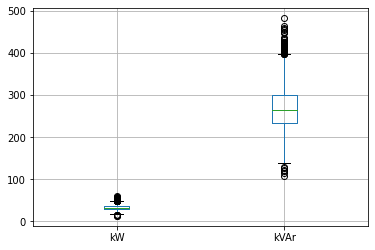

In [17]:
losses_many = run_monte_carlo(10000, actions = [change_loads], tools = [get_loss])
losses_df = reduce_losses(losses_many)
losses_df.boxplot(column=["kW", "kVAr"])

## Adding a new element.

Now that we have learned how to work with the three main concepts of DSSData, we can go a little further and add two 1.5 MW wind generators on the 675 and 680 nodes.

For this, we will initially create a class called ```WindTurbineGeneratorAbstraction``` that abstracts all the components of a wind turbine generator, keeping only the information and behaviors necessary for a study of power flow.

After creating the two instances of ```WindTurbineGeneratorAbstraction```, we included both generators in the OpenDSS commands.

In [18]:
#Create the wind generator class.
class WindTurbineGeneratorAbstraction():
    def __init__(self, kW, wind_rated, wind_cutin, wind_cutout, name):
        self.kW = kW
        self.wind_rated = wind_rated
        self.cutin = wind_cutin
        self.cutout = wind_cutout
        self.name = name

    #Linear Wind Turbine Generator power output model
    def power_output(self, wind_speed):
        if self.cutin < wind_speed and wind_speed <= self.wind_rated:            
            return self.kW * (wind_speed - self.cutin) / (self.wind_rated - self.cutin)

        elif self.wind_rated < wind_speed and wind_speed <= self.cutout:
            return self.kW
        else:
            return 0.

#Instance two wind generators.
myWTG1 = WindTurbineGeneratorAbstraction(1500, 11.8, 3.0, 20.0, "wg1")
myWTG2 = WindTurbineGeneratorAbstraction(1500, 11.8, 3.0, 20.0, "wg2")

#Include the two generators in the distribution system.
cmd = [
    f"New Generator.{myWTG1.name} bus1=675 Phases=3 kv=4.16 kw={myWTG1.kW} pf=1 model=1",
    f"New Generator.{myWTG2.name} bus1=680 Phases=3 kv=4.16 kw={myWTG2.kW} pf=1 model=1"
    ]
distSys.dsscontent = distSys.dsscontent + cmd


distSys.dsscontent[-1]

'New Generator.wg2 bus1=680 Phases=3 kv=4.16 kw=1500 pf=1 model=1'

## Change the behavior of a new element

In the same way that the loads must have a stochastic behavior, our wind turbine generators must also have. The Rayleigh distribution is normally used to model the stochastic wind speed behavior. In this way, we will create an ```Action``` called ```change_wtg``` to express this behavior.

We can check it by running the ```Action```.


> The ```Action``` generates a change in the distribution system that remains until the end of the execution of the power flow modes or ```SystemClass.init_sys``` method.


In [19]:
from numpy.random import rayleigh

wind_speed_mean = 7

@actions
def change_wtg(distSys, wg):
    #Create a wind speed from Rayleigh distribution.
    wind_speed = rayleigh(wind_speed_mean)

    #Get the power output from the Wind generator.
    power_out = wg.power_output(wind_speed)

    #Set the power output in the generator.
    distSys.run_command(f"Generator.{wg.name}.kw = {power_out}")

#Run the action.
change_wtg(distSys, myWTG1)
print( distSys.run_command(f"? Generator.{myWTG1.name}.kw") ) 

#Restart the distribution system.
distSys.init_sys()
print( distSys.run_command(f"? Generator.{myWTG1.name}.kw") )

84.4672
1500


However, an ``` Action``` is only properly executed within a power flow mode when it receives only the instance of ```SystemClass``` as an argument. Therefore, we created two other *Actions* based on ```change_wtg``` that exclusively alter one of the wind generators.

Finally, we can see the impact of the two generators on the IEEE 13 bus by running the ```run_mote_carlo``` again passing the two *Actions* created.

<AxesSubplot:>

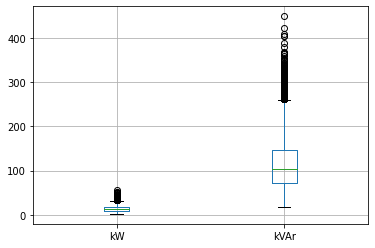

In [20]:
# Create a action for each Wind generator.
change_wtg1 = lambda distSys: change_wtg(distSys, myWTG1)
change_wtg2 = lambda distSys: change_wtg(distSys, myWTG2)

# Run the Monte Carlo with these actions.
losses = run_monte_carlo(
    10000, 
    actions = [change_loads, change_wtg1, change_wtg2], 
    tools = [get_loss]
)
losses_df = reduce_losses(losses)
losses_df.boxplot(column=["kW", "kVAr"])

That's all, folks. Now you can create your Action, Tool, and Reduction functions and simulate your super modern smart distribution system.